# Along Isopycnals

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from flox.xarray import xarray_reduce
import gsw

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import density_funcs as df
import plot_funcs as pf

In [83]:
from importlib import reload
reload(df)
reload(pf)

<module 'plot_funcs' from '/home/amf2288/argo-intern/funcs/plot_funcs.py'>

In [5]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

# Data wrangling

## Create ds_binned

In [4]:
ds = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/new_test.nc', chunks={'N_PROF':10000})
ds = ds.assign_attrs({"Fetched_uri":''})
unique_prof = np.arange(len(ds['N_PROF']))
ds = ds.assign_coords(N_PROF=('N_PROF', unique_prof))

In [6]:
ds

<xarray.Dataset> Size: 123GB
Dimensions:            (PRES_INTERPOLATED: 1001, N_PROF: 2550896)
Coordinates:
  * PRES_INTERPOLATED  (PRES_INTERPOLATED) int64 8kB 0 2 4 6 ... 1996 1998 2000
    TIME               (N_PROF) datetime64[ns] 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    LATITUDE           (N_PROF) float64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    LONGITUDE          (N_PROF) float64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
  * N_PROF             (N_PROF) int64 20MB 0 1 2 3 ... 2550893 2550894 2550895
Data variables:
    CT                 (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    CYCLE_NUMBER       (N_PROF) int64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    DATA_MODE          (N_PROF) <U1 10MB dask.array<chunksize=(10000,), meta=np.ndarray>
    DIRECTION          (N_PROF) <U1 10MB dask.array<chunksize=(10000,), meta=np.ndarray>
    PLATFORM_NUMBER    (N_PROF) int64 20MB dask.array<chunksize=(10000,), meta=np.ndarray>
    PRES               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    PSAL               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SA                 (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SIG0               (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    TEMP               (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    sample_rate        (N_PROF, PRES_INTERPOLATED) float32 10GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
    SPICE              (N_PROF, PRES_INTERPOLATED) float64 20GB dask.array<chunksize=(10000, 1001), meta=np.ndarray>
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_by:           amf2288
    Fetched_date:         2025/03/11
    Fetched_constraints:  [x=0.00/5.00; y=40.00/45.00; z=0.0/2002.0]
    Fetched_uri:          
    Valid uris:           ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    All uris:             ['https://data-argo.ifremer.fr/dac/coriolis/6903068...
    Processing_history:   [PRES,TEMP,PSAL] real-time and adjusted/delayed var...

In [7]:
lon_bins = np.arange(-180,181,1)
lat_bins = np.arange(-90,91,1)

In [8]:
numeric_vars = [var for var in ds if np.issubdtype(ds[var].dtype, np.number)]
ds = ds[numeric_vars]

In [9]:
def get_ds_binned(ds, lon_bins, lat_bins):
    
    ds_binned = xarray_reduce(
    ds,
    'LONGITUDE',
    'LATITUDE',
    func='mean',
    expected_groups=(
        pd.IntervalIndex.from_breaks(lon_bins),
        pd.IntervalIndex.from_breaks(lat_bins)
    ),
    fill_value=np.nan,
    skipna=True)
    
    lon_l = np.arange(lon_bins[0],lon_bins[-1],1)
    lon_r = np.arange(lon_bins[1],lon_bins[-1]+1,1)
    lon_c = (lon_l + lon_r)/2

    lat_l = np.arange(lat_bins[0],lat_bins[-1],1)
    lat_r = np.arange(lat_bins[1],lat_bins[-1]+1,1)
    lat_c = (lat_l + lat_r)/2

    ds_binned = ds_binned.assign_coords({
        "lat_c": ("LATITUDE_bins", lat_c),
        "lat_l": ("LATITUDE_bins", lat_l),
        "lat_r": ("LATITUDE_bins", lat_r),
        "lon_c": ("LONGITUDE_bins", lon_c),
        "lon_l": ("LONGITUDE_bins", lon_l),
        "lon_r": ("LONGITUDE_bins", lon_r),
    })
    
    ds_binned = ds_binned.swap_dims({"LATITUDE_bins": "lat_c", "LONGITUDE_bins": "lon_c"})
    ds_binned = ds_binned.drop_vars(["LATITUDE_bins", "LONGITUDE_bins"])
    
    if isinstance(ds_binned, xr.Dataset):
        # For xarray.Dataset, use rename_dims and rename_vars
        ds_binned = ds_binned.rename_dims({"PRES_INTERPOLATED": "z_c"}).rename_vars({"PRES_INTERPOLATED": "z_c"})
    elif isinstance(ds_binned, xr.DataArray):
        # For xarray.DataArray, use rename to rename the dimension
        ds_binned = ds_binned.rename({"PRES_INTERPOLATED": "z_c"})
    else:
        raise TypeError("Input must be an xarray.Dataset or xarray.DataArray")

    
    return ds_binned

In [10]:
ds_binned = get_ds_binned(ds, lon_bins, lat_bins)

In [11]:
%%time
ds_binned = ds_binned.chunk({'z_c':20}).load()

CPU times: user 1h 45min 37s, sys: 7h 28s, total: 8h 46min 6s
Wall time: 35min 16s


In [20]:
ds_binned.to_netcdf('/swot/SUM05/amf2288/sync-boxes/globe_binned_z.nc')

## Load ds_binned and plot

In [21]:
ds_binned = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/globe_binned_z.nc', chunks={'z_c':20}).load()

In [22]:
depth = 500
ds_sel = ds_binned.sel(z_c=depth, method='nearest').compute()

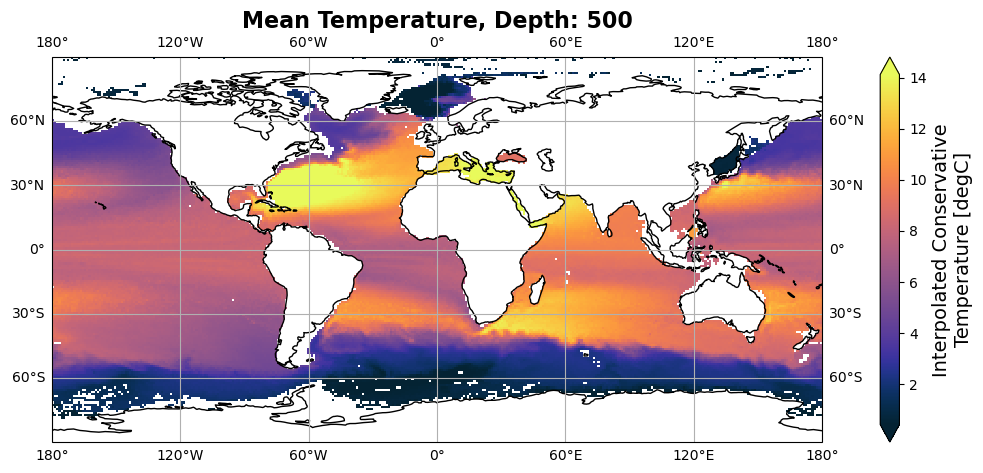

In [23]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_sel.CT.plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.thermal, robust=True)
ax.set_title('Mean Temperature, Depth: {}'.format(depth));

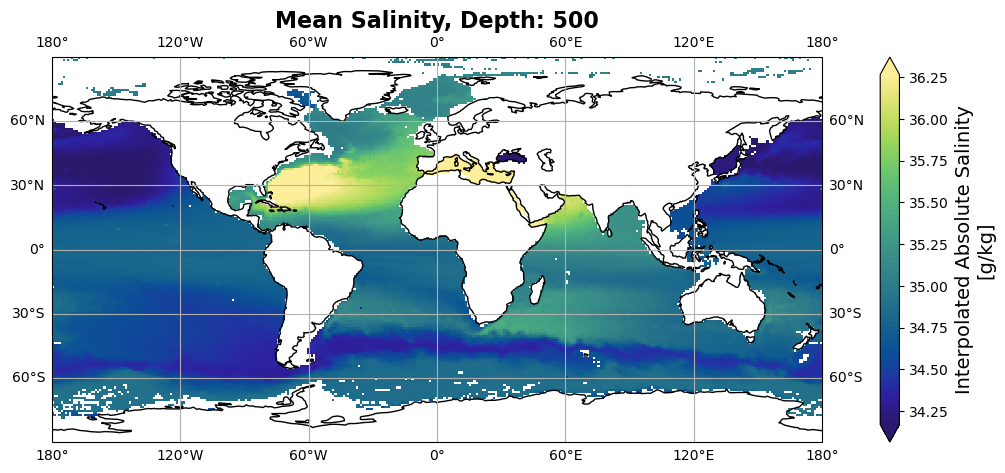

In [24]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_sel.SA.plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.haline, robust=True)
ax.set_title('Mean Salinity, Depth: {}'.format(depth));

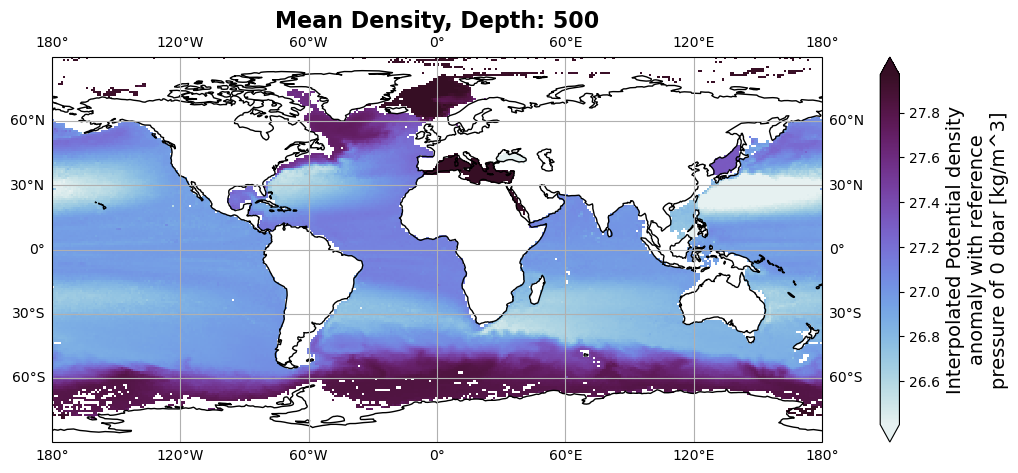

In [25]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_sel.SIG0.plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.dense, robust=True)
ax.set_title('Mean Density, Depth: {}'.format(depth));

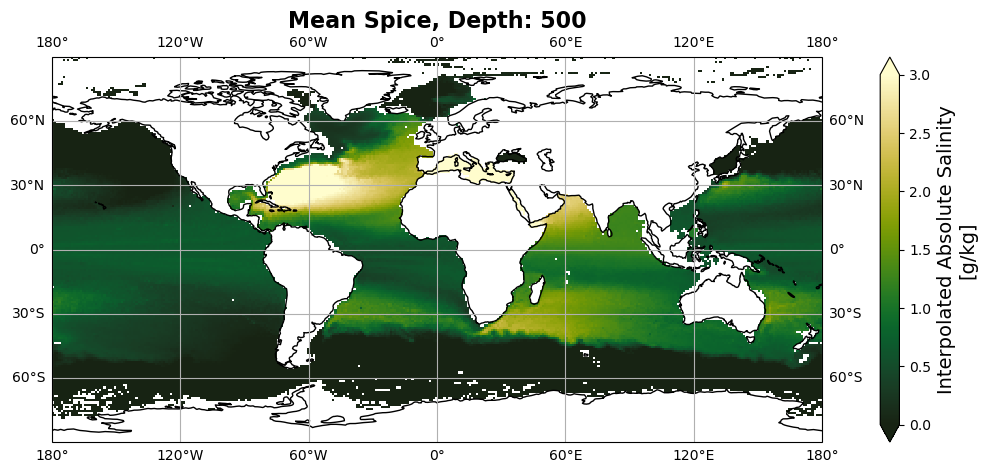

In [26]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_sel.SPICE.plot(x='lon_c',y='lat_c',ax=ax,transform=ccrs.PlateCarree(), cmap=cmo.speed_r, vmin=0, vmax=3)
ax.set_title('Mean Spice, Depth: {}'.format(depth));

## Create ds_rho

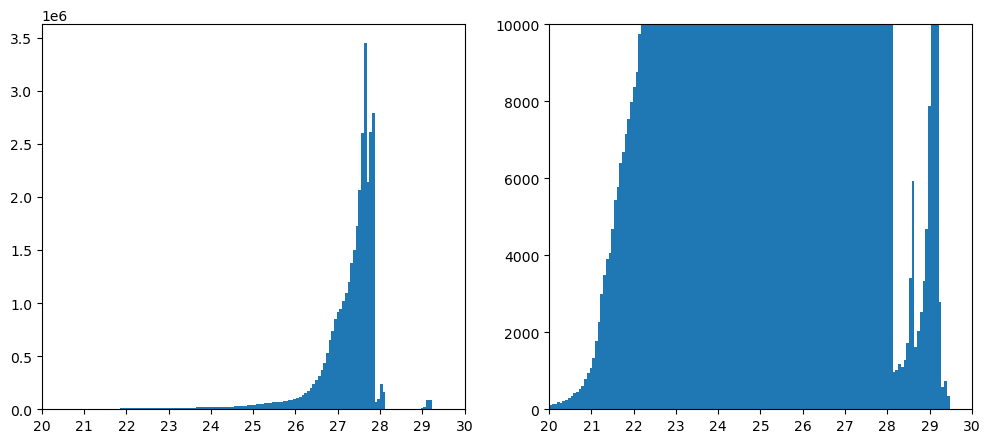

In [76]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(ds_binned.SIG0.values.flatten(), bins=500)
plt.xlim(20,30)
plt.xticks(ticks=np.arange(20,31,1),labels=np.arange(20,31,1));

plt.subplot(122)
plt.hist(ds_binned.SIG0.values.flatten(), bins=500)
plt.xlim(20,30)
plt.ylim(0,1e4)
plt.xticks(ticks=np.arange(20,31,1),labels=np.arange(20,31,1));

In [77]:
rho_grid = np.arange(21,29,0.0025)

In [78]:
len(rho_grid)

3200

In [79]:
#this makes all values of nan -100
#ds_binned = ds_binned.fillna(-100)

In [80]:
#this makes all values of -100 nan
#ds_binned = ds_binned.where(ds_binned != -100, np.nan)

In [81]:
%%time
ds_binned = ds_binned.chunk({"lon_c": 20, "lat_c": 20, "z_c":1001}).load()

CPU times: user 7.04 s, sys: 3.67 s, total: 10.7 s
Wall time: 10.7 s


In [84]:
%%time
ds_rho = df.density_interp_binned(ds_binned, rho_grid)

z_c concat complete
CT concat complete
SA concat complete
SIG0 concat complete
SPICE concat complete
ds_rho merge complete
CPU times: user 1h 53min 16s, sys: 1min 43s, total: 1h 54min 59s
Wall time: 1h 54min 58s


In [85]:
ds_rho

<xarray.Dataset> Size: 8GB
Dimensions:   (rho_grid: 3200, lon_c: 360, lat_c: 180)
Coordinates:
  * rho_grid  (rho_grid) float64 26kB 21.0 21.0 21.01 21.01 ... 28.99 29.0 29.0
  * lon_c     (lon_c) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat_c     (lat_c) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    z_c       (rho_grid, lon_c, lat_c) float64 2GB nan nan nan ... nan nan nan
    CT        (rho_grid, lon_c, lat_c) float64 2GB nan nan nan ... nan nan nan
    SA        (rho_grid, lon_c, lat_c) float64 2GB nan nan nan ... nan nan nan
    SIG0      (rho_grid, lon_c, lat_c) float64 2GB nan nan nan ... nan nan nan
    SPICE     (rho_grid, lon_c, lat_c) float64 2GB nan nan nan ... nan nan nan

In [111]:
ds_rho = ds_rho.rename({'rho_grid':'density'})

In [113]:
ds_rho.to_netcdf('/swot/SUM05/amf2288/sync-boxes/globe_binned_rho.nc')

## Load ds_rho and plot

In [116]:
ds_rho = xr.open_dataset('/swot/SUM05/amf2288/sync-boxes/globe_binned_rho.nc', chunks={'density':50})

In [124]:
density = 26.8

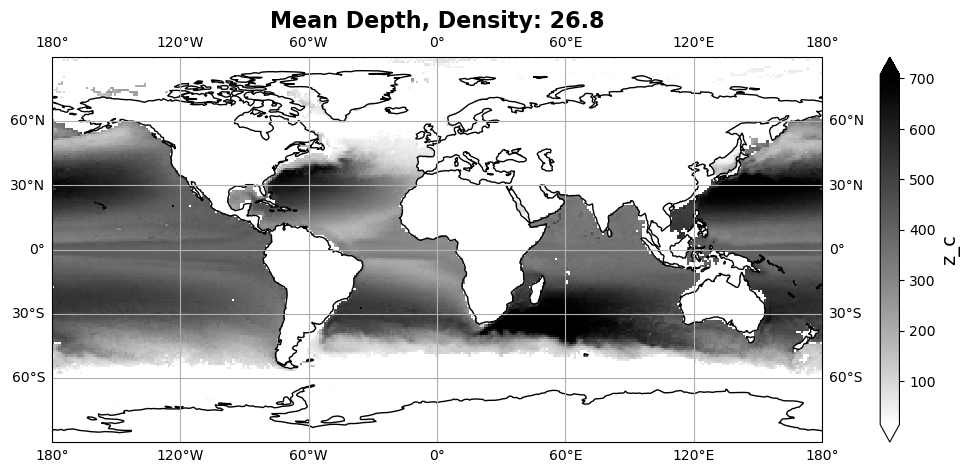

In [127]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_rho.sel(density=density, method='nearest').z_c.plot(x='lon_c', y='lat_c', ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.gray_r, robust=True)
ax.set_title('Mean Depth, Density: {}'.format(density));

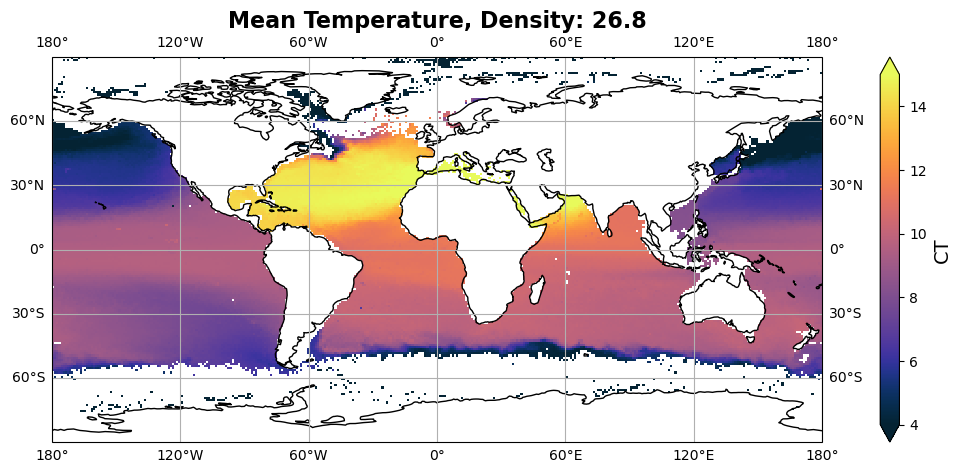

In [138]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_rho.sel(density=density, method='nearest').CT.plot(x='lon_c', y='lat_c', ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.thermal, vmin=4, vmax=15)
ax.set_title('Mean Temperature, Density: {}'.format(density));

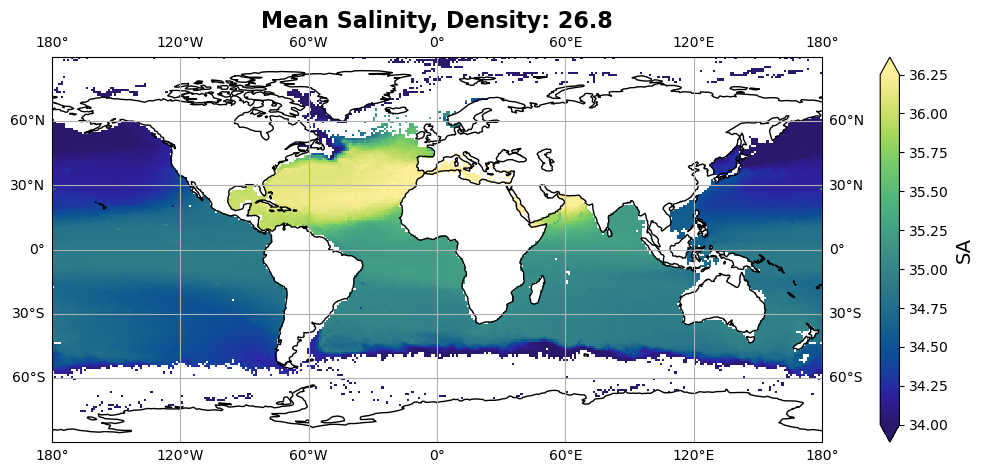

In [140]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_rho.sel(density=density, method='nearest').SA.plot(x='lon_c', y='lat_c', ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.haline, vmin=34, vmax=36.25) 
ax.set_title('Mean Salinity, Density: {}'.format(density));

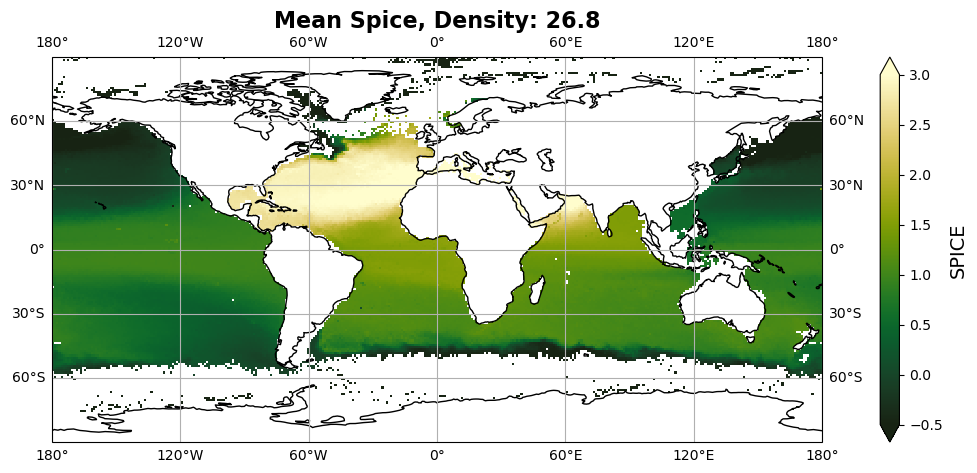

In [141]:
fig=plt.figure(figsize=(15,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_global()
ds_rho.sel(density=density, method='nearest').SPICE.plot(x='lon_c', y='lat_c', ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.speed_r, vmin=-0.5, vmax=3)
ax.set_title('Mean Spice, Density: {}'.format(density));

# Calculate Lateral Gradeints

# Calculate DSC

In [ ]:
def calculate_DSC(ds):
    alpha = gsw.alpha(ds.SA, ds.CT, ds.PRES)
    theta_sig_sig = ds.CT.differentiate(coord='rho_grid').differentiate(coord='rho_grid')
    
    DSC = 2*alpha*ds.SIG0*theta_sig_sig
    
    ds['DSC'] = (['rho_grid', 'lat_c'. 'lon_c'], DSC)
    
    return ds

In [ ]:
calculate_DSC(ds_rho)